# Track inner droplet with predictive cropping and HoughCircles

In this notebook, I implement the droplet tracking software using the following idea 
- crop the raw images so that inner droplet makes the majority of the cropped image
- use HoughCircles method to locate the droplet in the cropped image


The cropping in the next frame is determined based on the position detected on the previous frame. If droplet can be detected on every frame, this method should work perfectly. If there are some frames where droplet is missing (i.e. the return value of HoughCircles is None), we use the previous frame info to determine the crop. 

In [16]:
import numpy as np
from skimage import io
import os
import matplotlib.pyplot as plt
import cv2
import matplotlib.patches as mpatch

## 1 Test idea

In [3]:
stack = io.imread('video-sample.tif')

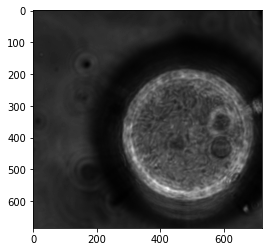

In [7]:
plt.imshow(stack[0], cmap='gray')

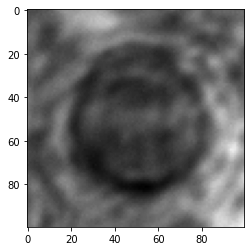

In [11]:
# we describe the crop by (upper, lower, left, right) tuple
crop = (380, 480, 540, 640)
cropped = stack[0][crop[0]:crop[1], crop[2]:crop[3]]
plt.imshow(cropped, cmap='gray')

In [18]:
# For this video, cropped image size (100, 100) is sufficient
circles = cv2.HoughCircles(cropped, cv2.HOUGH_GRADIENT, 1, 200, param2=1, maxRadius=40, minRadius=25)
circles

array([[[54.5, 49.5, 36. ]]], dtype=float32)

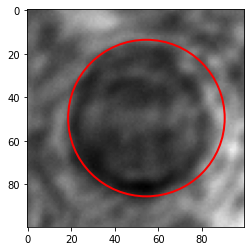

In [19]:
fig, ax = plt.subplots()
ax.imshow(cropped, cmap='gray')
for c in circles[0, :, :]:
    circle_object = mpatch.Circle((c[0], c[1]), c[2],
                                 fill=False, ec='red', lw=2)
    ax.add_patch(circle_object)

In [26]:
# determine the crop of the next image
x0, y0 = 430, 590
crop_size = 50
if circles is not None:
    x, y = int(circles[0, 0, 0]+x0-crop_size), int(circles[0, 0, 1]+y0-crop_size)
    crop = [x - crop_size, x + crop_size, y - crop_size, y + crop_size]

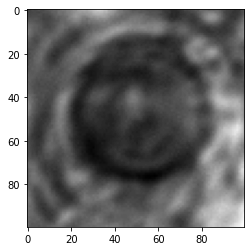

In [27]:
cropped = stack[1][crop[0]:crop[1], crop[2]:crop[3]]
plt.imshow(cropped, cmap='gray')

In [28]:
# detect circle in frame 2 (stack[1])
circles = cv2.HoughCircles(cropped, cv2.HOUGH_GRADIENT, 1, 200, param2=1, maxRadius=40, minRadius=25)
circles

array([[[53.5, 45.5, 33.8]]], dtype=float32)

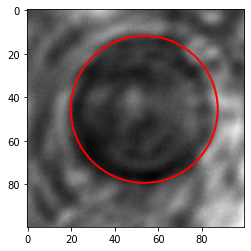

In [29]:
fig, ax = plt.subplots()
ax.imshow(cropped, cmap='gray')
for c in circles[0, :, :]:
    circle_object = mpatch.Circle((c[0], c[1]), c[2],
                                 fill=False, ec='red', lw=2)
    ax.add_patch(circle_object)

In [ ]:
# This loop can keep going 
# It breaks down when droplet cannot be detected for a long period
# in that case, either try take better video, or segment the video into pieces where droplet can be always detected

## 2 The testing loop

0 [380 540]
[[[54.5 49.5 36. ]]]


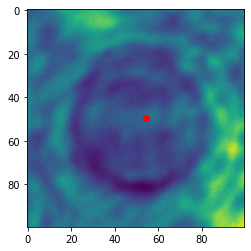

1 [379 544]
[[[48.5 50.5 33.8]]]


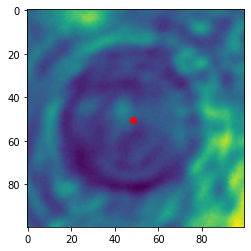

2 [379 542]
[[[46.5 49.5 36.1]]]


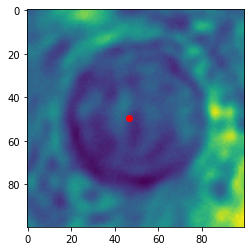

3 [378 538]
[[[48.5 45.5 38.3]]]


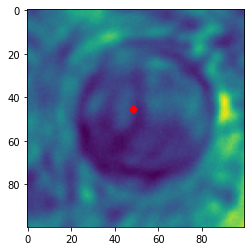

4 [373 536]
[[[54.5 51.5 33.8]]]


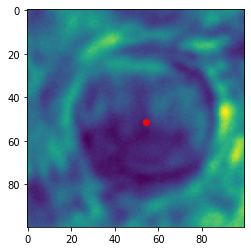

5 [374 540]
[[[47.5 48.5 35.8]]]


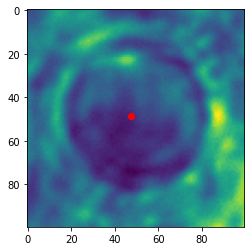

6 [372 537]
[[[45.5 49.5 37.1]]]


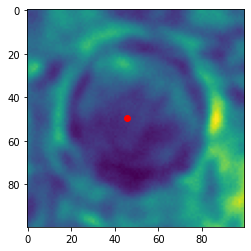

7 [371 532]
[[[47.5 48.5 37.1]]]


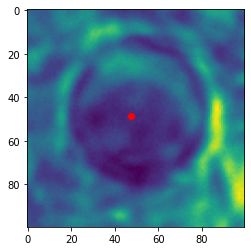

8 [369 529]
[[[49.5 44.5 33.8]]]


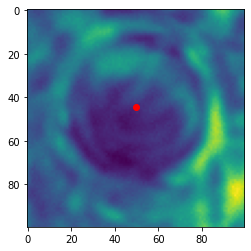

9 [363 528]
[[[47.5 48.5 32.6]]]


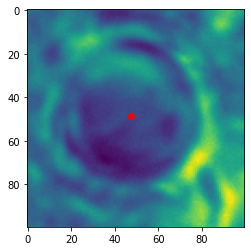

[594, 592, 588, 586, 590, 587, 582, 579, 578, 575]
[429, 429, 428, 423, 424, 422, 421, 419, 413, 411]


In [83]:
# Initial params
crop_anchor = np.array([380, 540]) # upper left corner coords
crop_size = (100, 100) # height and width
# HoughCircles params
Hough_dp = 1
Hough_minDist = max(crop_size)
Hough_param2 = 1
Hough_maxRadius = 40
Hough_minRadius = 25

# initialize result containers
x_list = []
y_list = []
t_list = []

stack = io.imread('video-sample.tif')
for t, img in enumerate(stack):    
    crop = (crop_anchor[0], crop_anchor[0]+crop_size[0],
           crop_anchor[1], crop_anchor[1]+crop_size[1])
    # need to check if the crop exceeds the borders of images
    cropped = img[crop[0]:crop[1], crop[2]:crop[3]]
    #     print(t, crop_anchor)   
    
    circles = cv2.HoughCircles(cropped, cv2.HOUGH_GRADIENT, Hough_dp, Hough_minDist, 
                               param2=Hough_param2, maxRadius=Hough_maxRadius, minRadius=Hough_minRadius)
    if circles is not None:
        print(circles)
        x, y = int(circles[0, 0, 0]+crop_anchor[1]), int(circles[0, 0, 1]+crop_anchor[0])
        # NOTE: the circle coords given by HoughCircles is in (x, y), i.e. horizontal then vertical 
        #       to be consistent with the row-column coords, we need to put circles[0,0,1] as the "row" #
        #       and circles[0,0,0] as the "column" #
        crop_anchor = np.array([y-crop_size[1]/2, x-crop_size[0]/2]).astype('int')
    else:
        x, y = np.nan, np.nan
        
#     plt.imshow(cropped)
#     plt.plot(circles[0, 0, 0], circles[0, 0, 1], marker='o', color='red')
#     plt.pause(0.001)
    t_list.append(t)
    x_list.append(x)
    y_list.append(y)
print(x_list)
print(y_list)
#     break

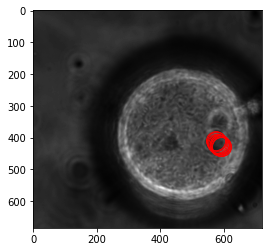

In [86]:
# draw the trajectory
fig, ax = plt.subplots()
ax.imshow(img, cmap='gray')
for x, y in zip(x_list, y_list):
    circle_object = mpatch.Circle((x, y), 30,
                                 fill=False, ec='red', lw=1)
    ax.add_patch(circle_object)

**Comments:**
- the tracking works well for the 10 frame test
- need to develop tools that can promptly locate the frame where error occurs
    - save cropped images: if no droplet can be found there, that's where error occurs
    - save the length of HoughCircles results (circles): if too many circles are detected or no circle is detected for too long, there is a problem
- predict cropping region using velocity information
- the HoughCircles params can be adaptive